## Step 1: Visualizing Stereo Image Pair in Anaglyph Style
We will start by loading the left and right images and visualize them in an anaglyph style (cyan-red overlay). This will help us see the vertical disparity between the two images.

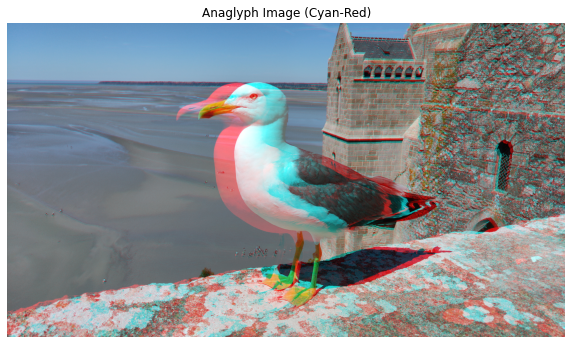

In [71]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load the stereo image pair in color
left_image_color = cv2.imread('output/albedo_0.jpg')
right_image_color = cv2.imread('output/albedo_1.jpg')
height, width = left_image_color.shape[:2]

# Convert color images to grayscale for phase correlation
left_image_gray = cv2.cvtColor(left_image_color, cv2.COLOR_BGR2GRAY)
right_image_gray = cv2.cvtColor(right_image_color, cv2.COLOR_BGR2GRAY)

# Create anaglyph style overlay: left image Cyan, right image Red
anaglyph_image = np.zeros_like(left_image_color)
anaglyph_image[..., 2] = right_image_color[..., 2]  # Red channel
anaglyph_image[..., 1] = left_image_color[..., 1]   # Green channel
anaglyph_image[..., 0] = left_image_color[..., 0]   # Blue channel

# Plot the anaglyph image
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(anaglyph_image, cv2.COLOR_BGR2RGB))
plt.title("Anaglyph Image (Cyan-Red)")
plt.axis('off')
plt.show()

## Step 2: Detecting and Correcting Vertical Disparity using Affine Transformation
Now, we will use `cv2.phaseCorrelate` to compute the vertical disparity between the grayscale versions of the left and right images. We will then apply a vertical shift using `cv2.warpAffine` to minimize the disparity and replot the anaglyph overlay for comparison.

Vertical Shift: -17.7002997473287


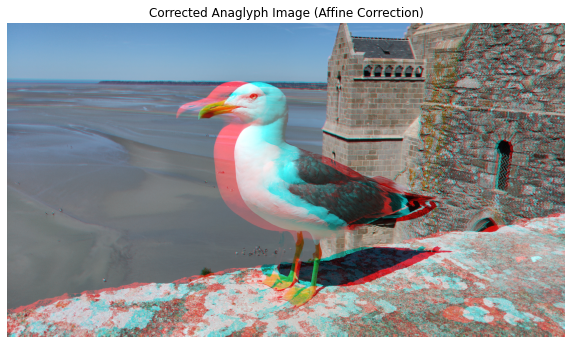

In [86]:
# Use phase correlation on grayscale images to compute vertical disparity
shift, _ = cv2.phaseCorrelate(np.float32(left_image_gray), np.float32(right_image_gray))

# Extract the vertical component of the shift (only care about vertical shift)
vertical_shift = shift[1]
print("Vertical Shift:", -vertical_shift)

# Compute the affine transformation matrix for vertical translation
translation_matrix_right = np.float32([[1, 0, 0], [0, 1, -vertical_shift]])

# Apply vertical translation to both color images
shifted_right_image_color_affine = cv2.warpAffine(right_image_color, translation_matrix_right, (right_image_color.shape[1], right_image_color.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

# Create a new anaglyph image after affine correction
corrected_anaglyph_image_affine = np.zeros_like(left_image_color)
corrected_anaglyph_image_affine[..., 2] = shifted_right_image_color_affine[..., 2]  # Red channel
corrected_anaglyph_image_affine[..., 1] = left_image_color[..., 1]   # Green channel
corrected_anaglyph_image_affine[..., 0] = left_image_color[..., 0]   # Blue channel

# Plot the corrected anaglyph image (Affine Correction)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(corrected_anaglyph_image_affine, cv2.COLOR_BGR2RGB))
plt.title("Corrected Anaglyph Image (Affine Correction)")
plt.axis('off')
plt.show()

In [78]:
cv2.imwrite('output/albedo_1_corY.jpg', shifted_right_image_color_affine)

True

## Step 1: Detect Keypoints and Eliminate Vertical Outliers
We'll start by detecting keypoints and descriptors in both the left and right images using ORB. We'll then match these keypoints and filter out any pairs that have vertical disparities greater than 3% of the image height.

Number of matches before filtering: 243 ater filtering: 206


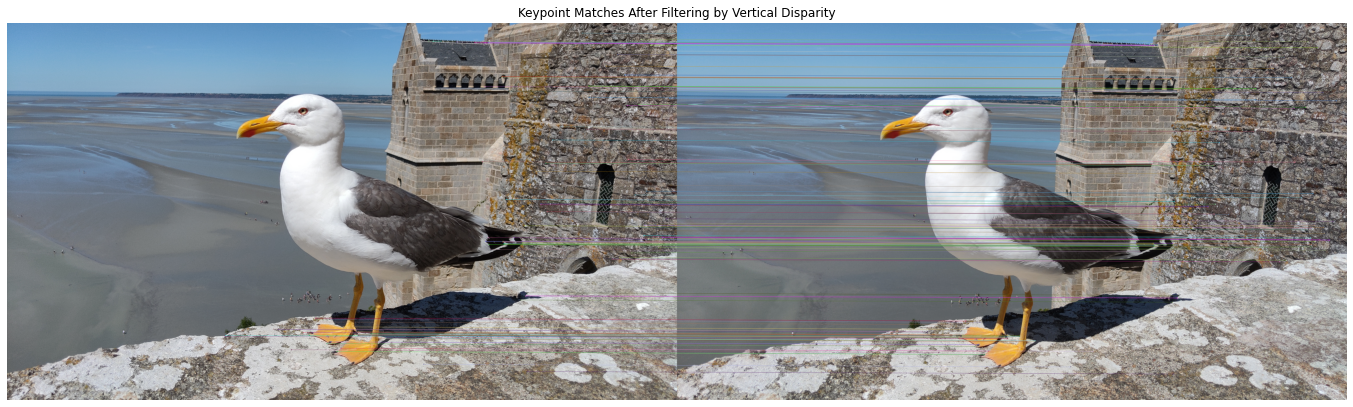

In [84]:
# Image height for filtering threshold
image_height = left_image_color.shape[0]

# Initialize ORB detector
orb = cv2.ORB_create()

# Detect keypoints and descriptors
keypoints_left, descriptors_left = orb.detectAndCompute(left_image_color, None)
keypoints_right, descriptors_right = orb.detectAndCompute(right_image_color, None)

# Use BFMatcher to find the best matches between the two sets of descriptors
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors_left, descriptors_right)

# Filter matches by vertical disparity (y-axis difference)
filtered_matches = []
threshold = 0.03 * image_height  # 3% of image height

for match in matches:
    left_point = keypoints_left[match.queryIdx].pt
    right_point = keypoints_right[match.trainIdx].pt
    vertical_disparity = abs(left_point[1] - right_point[1])
    
    if vertical_disparity <= threshold:
        filtered_matches.append(match)

print("Number of matches before filtering:", len(matches), "ater filtering:", len(filtered_matches))

# Draw and display matches for visualization purposes
matching_result = cv2.drawMatches(left_image_color, keypoints_left, right_image_color, keypoints_right, filtered_matches, None, flags=2)

plt.figure(figsize=(24, 12))
plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))
plt.title("Keypoint Matches After Filtering by Vertical Disparity")
plt.axis('off')
plt.show()

## Step 2: Optimize y-Translation and Scaling
We'll now optimize the vertical translation and uniform scaling that minimizes the RMS difference in vertical disparity between the keypoints in the left image and those in the adjusted right image.

In [80]:
# Collect points from filtered matches
left_points = np.float32([keypoints_left[m.queryIdx].pt for m in filtered_matches])
right_points = np.float32([keypoints_right[m.trainIdx].pt for m in filtered_matches])

def compute_rms_disparity(y_translation, scaling, left_points, right_points):
    # Apply scaling and vertical translation to the right points
    adjusted_right_points = right_points.copy()
    adjusted_right_points[:, 0] *= scaling  # Apply uniform scaling to x
    adjusted_right_points[:, 1] = adjusted_right_points[:, 1] * scaling + y_translation  # Apply scaling and vertical shift to y
    
    # Compute RMS of the vertical disparity
    vertical_disparity = left_points[:, 1] - adjusted_right_points[:, 1]
    rms = np.sqrt(np.mean(vertical_disparity**2))
    return rms

# Search for the best combination of y translation and scaling that minimizes the RMS
# Initial guess: no scaling, no vertical translation
initial_guess = [0, 1.0]

# Minimize the RMS disparity
result = minimize(lambda params: compute_rms_disparity(params[0], params[1], left_points, right_points), initial_guess, method='Powell')

# Extract the optimal y translation and scaling values
optimal_y_translation, optimal_scaling = result.x
print(f"Optimal y-Translation: {optimal_y_translation:.2f}, Optimal Scaling: {optimal_scaling:.4f}")

Optimal y-Translation: -16.09, Optimal Scaling: 0.9993


## Step 3: Apply Affine Transformation to Right Image
Using the optimal vertical translation and scaling found, we'll apply an affine transformation to the right image to align it with the left image.

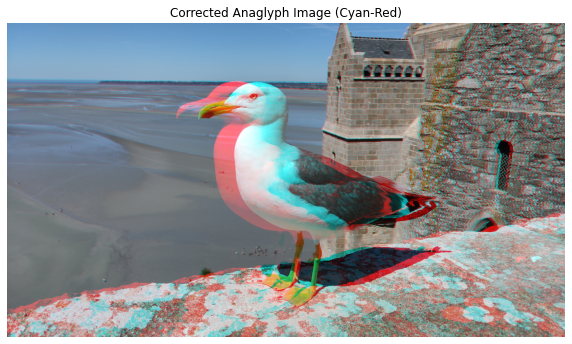

In [81]:
# Compute affine transformation matrix
affine_matrix = np.float32([[optimal_scaling, 0, 0], [0, optimal_scaling, optimal_y_translation]])

# Apply the affine transformation to the right image
adjusted_right_image_color = cv2.warpAffine(right_image_color, affine_matrix, (right_image_color.shape[1], right_image_color.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

# Create a new anaglyph image after correction
corrected_anaglyph_image = np.zeros_like(left_image_color)
corrected_anaglyph_image[..., 2] = adjusted_right_image_color[..., 2]  # Red channel
corrected_anaglyph_image[..., 1] = left_image_color[..., 1]   # Green channel
corrected_anaglyph_image[..., 0] = left_image_color[..., 0]   # Blue channel

# Plot the corrected anaglyph image
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(corrected_anaglyph_image, cv2.COLOR_BGR2RGB))
plt.title("Corrected Anaglyph Image (Cyan-Red)")
plt.axis('off')
plt.show()

In [82]:
cv2.imwrite('output/albedo_1_corYS.jpg', adjusted_right_image_color)

True